Исследование зависимости конверсии и платежей от выбранного уровня сложности
============================================================================

Краткие выводы для занятых
---------------------------------------------

Выбранный пользователем уровень сложности:

 - Очень тесно связан с конверсией;
 - Связан со временем, которое проходит от регистрации или выбора уровня до оплаты;
 - Слабо связан со средним чеком.


Цель работы
-----------

### Гипотезы

проверить два предположения:

-   Зависит ли вероятность оплаты от выбранного пользователем уровня
    сложности бесплатных тренировок?
-   Существует ли разница во времени между выбором уровня сложности и
    оплатой между пользователями, выбирающими разные уровни сложности?

### Ограничения:

-   Результат должен быть в Jupyter Notebook.
-   Использовать данные пользователей, зарегистрированных в 2017 г.

Поскольку работаем в Jupyter, и база не моя, нельзя использовать
представления и временные таблицы. Буду выкручиваться через CTE.

### Дополнительные условия

В учебной базе объём данных не слишком серьёзный. Но при обработке
данных из БД обычна ситуация, когда данных больше, чем может вместиться
в памяти (особенно в памяти персонального компьютера). К счастью, все
данные и не нужно тащить в память — у нас есть целая СУБД, которая
сделает любые выборки, объединения и сортировки. Нужно только правильно
ей пользоваться.

Что мы уже знаем?
-------------------------

На рисунке ниже приведен результат исследования путей пользователей в приложении.



Числа в блоках: число уникальных пользователей, совершивших событие
Числа на стрелках: число переходов пользователей непосредственно между блоками (здесь пользователи не обязательно уникальны)

За работу!
----------

Импорт библиотек:

In [1]:
    import pandas as pd
    import psycopg2
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set()
    sns.set_style("whitegrid")

Определение констант:

Чтобы не хранить пароли в ГитХабе (порочная практика :) ), записал их в
отдельные файлы и подключаю через импорт.  К сожалению, именно для сдачи
работы на проверку такой вариант не подходит, пришлось вставить содержимое
файла `SkillFactory_DB` прямо сюда.

In [2]:
    # constants
    
    # there are two modules with only constants defined: one for local DB
    # and another for remote (SkillFactory) database. Only one has to be enabled
    # in any given time
    # ---
    # from SkillFactory_DB import DB_NAME, DB_USER, DB_HOST, DB_PORT, DB_PASSWD
    # from Local_DB        import DB_NAME, DB_USER, DB_HOST, DB_PORT, DB_PASSWD

    # -- Для возможности проверки вставил содержимое 'SkillFactory_DB.py' сюда --
    DB_NAME = 'skillfactory'
    DB_USER = 'skillfactory'
    DB_HOST = 'lms.skillfactory.ru'
    DB_PORT = 5432
    DB_PASSWD = 'cCkxxLVrDE8EbvjueeMedPKt'
    # -- конец вставки --
    
    DB_CONNECT_STRING = "dbname={0} host={1} port={2} user={3} password={4}".format(
        DB_NAME, DB_HOST, DB_PORT, DB_USER, DB_PASSWD
    )

Начальная и конечная даты для исследования. Первая включается в
диапазон, вторая нет.

In [3]:
    START_DATE = '2017-01-01'   # this day will be included
    END_DATE   = '2018-01-01'   # and this will be not

Далее множество шаблонов для CTE и SQL запросов.

In [4]:
    # template for SQL expression: all users registered btw two dates list
    ALL_USERS_TMPL = """\
        SELECT DISTINCT user_id
        FROM case8.events
        WHERE event_type = 'registration'
        AND start_time BETWEEN '{0}' AND '{1}'
    """

    # Только покупатели
    BUYERS_TMPL = """\
        SELECT DISTINCT user_id
        FROM case8.purchase
        INTERSECT
        SELECT DISTINCT user_id
        FROM case8.events
        WHERE event_type = 'registration'
        AND start_time BETWEEN '{0}' AND '{1}'
    """

    # Теперь выделим пользователей и покупателей заданного временного диапазона
    USERS   = ALL_USERS_TMPL.format(START_DATE, END_DATE)
    BUYERS  = BUYERS_TMPL.format(START_DATE, END_DATE)

    # и запишем CTE для этих групп (Практически списков USER_ID - ов)
    USERS17_CTE = """users_2017 as (
        {}
    )""".format(USERS)

    BUYERS17_CTE = """buyers_2017 as (
        {} 
    )""".format(BUYERS)

    # Вместо представлений определим CTE для событий, производимых пользователями
    # 2017 года регистрации, и их покупок
    EVENTS17_CTE = """events_2017 as (
        select * from case8.events
        inner join
        users_2017
        using (user_id)
    )"""

    PURCHASES17_CTE = """purchases_2017 as (
        select * from case8.purchase
        inner join
        users_2017
        using (user_id)
    )"""

Зависит ли вероятность оплаты от выбранного пользователем уровня сложности бесплатных тренировок?
-------------------------------------------------------------------------------------------------

Вооружившись таким набором констант, получим
списки пользователей, выбирающих разные уровни сложности в приложении.
Уровней у нас всего три: `hard`, `medium` и `easy`.

Определю функцию, которая соединяется с базой, настраивает параметры
соединения, создаёт курсор и возвращает его.

In [5]:
    def init_connect(conn_string: "PostgreSQL connection string") -> psycopg2.extensions.cursor:
        """Connect to DB using connection string from 1st parameter. Return the cursor"""
        db_conn = psycopg2.connect(conn_string)
        cursor = None
        if db_conn:
            db_conn.set_session(readonly=True,autocommit=True)
            cursor = db_conn.cursor()
        return cursor

Связываемся с базой для того, чтобы отправлять в неё запросы:

In [6]:
cursor = init_connect(DB_CONNECT_STRING)

И мы уже можем посчитать конверсию по пользвователям разных уровней сложности:

In [7]:
    curr_cte = 'with ' + ', '.join((USERS17_CTE, EVENTS17_CTE, PURCHASES17_CTE))

    lvl_req_template = """
    select
        selected_level,
        count(user_id) as users,
        count(amount)  as buyers,
        sum(amount)    as revenue,
        count(amount)*1.0/count(user_id) as "conversion",
        avg(amount)    as avg_check
    from
        events_2017
        left join
        purchases_2017
        using (user_id)
    where events_2017.event_type = 'level_choice'
    group by selected_level
    order by conversion desc;
    """
    conversion_request = curr_cte + " " + lvl_req_template
    
    # Здесь я один раз распечтаю сгенерированный запрос, просто для того, чтобы было видно, что
    # запрашивается у СУБД
    print("===== SQL Query for conversion rate =====\n{}\n{}".format(conversion_request, 80 * '-'))
    
    cursor.execute(conversion_request)
    ret = cursor.fetchall()
    conv_df = pd.DataFrame.from_records(ret, columns=('level', 'users', 'buyers', 'revenue', 'conversion', 'avg_check'), index='level')
    print(conv_df.to_string(formatters={'conversion': '{:.2%}'.format, 'avg_check': '{:.2f} р.'.format}))

===== SQL Query for conversion rate =====
with users_2017 as (
        SELECT DISTINCT user_id
    FROM case8.events
    WHERE event_type = 'registration'
    AND start_time BETWEEN '2017-01-01' AND '2018-01-01'

), events_2017 as (
    select * from case8.events
    inner join
    users_2017
    using (user_id)
), purchases_2017 as (
    select * from case8.purchase
    inner join
    users_2017
    using (user_id)
) 
select
    selected_level,
    count(user_id) as users,
    count(amount)  as buyers,
    sum(amount)    as revenue,
    count(amount)*1.0/count(user_id) as "conversion",
    avg(amount)    as avg_check
from
    events_2017
    left join
    purchases_2017
    using (user_id)
where events_2017.event_type = 'level_choice'
group by selected_level
order by conversion desc;

--------------------------------------------------------------------------------
        users  buyers  revenue conversion  avg_check
level                                               
hard     1249   

В результате выводится табличка:

| level  |  users|  buyers|  revenue|  conversion|  avg\_check|
|:-------|------:|-------:|--------:|-----------:|-----------:|
| hard   |   1249|     442|    49235|      35.39%|   111.60 р.|
| medium |   4645|     969|   106125|      20.86%|   109.52 р.|
| easy   |   2448|     189|    21725|       7.72%|   114.95 р.|

### Вывод по первому вопросу:

Существует зависимость между уровнем сложности и конверсией.
Пользователи, которые выбирают уровни *hard* и *medium*, чаще оплачивают
тренировки. При этом больше всего прибыли приносят пользователи уровня
*medium* за счёт большего числа таких пользователей.

Зависимости между средним чеком и уровнем сложности тренировок не
обнаружено.

Исследование временных промежутков между выбором уровня и оплатой.
------------------------------------------------------------------

Нужно построить представление, в котором будет колонки: `user_id`,
`selected_level`, `level_choice_time_stamp`, `purchase_time_stamp`,
`time_difference`. Названия говорят сами за себя. Для этого объединим
CTE `events_2017` и `purchases_2017` через INNER JOIN по полю `user_id`,
тогда останутся только покупатели.

In [8]:
    curr_cte = 'with ' + ', '.join((USERS17_CTE, EVENTS17_CTE, PURCHASES17_CTE))

    cursor.execute(curr_cte + """
    select 
        user_id,
        selected_level,
        lc.start_time as level_choice_ts,
        pur.start_time as purchase_ts,
        (pur.start_time - lc.start_time) as time_diff
    from
        events_2017 as lc
        inner join
        purchases_2017 as pur
        using(user_id)
        where lc.event_type='level_choice'
    limit 5;
    """)
    ret = cursor.fetchall()

    # И это немножко замороченное выражение печатает пример данных после фильтрации и объединения
    # Проще было преобразовать результаты запроса  в датафрейм и напечатать средствами Pandas.
    print("{0:8s} {1:8s} {2:23s} {3:23s} {4:20s}\n{5}".format(
            "User ID", "Level", "Lvl choice time", "Purchase time", "Interval", '-'*85
         ))
    print('\n'.join(['\t'.join([str(f) for f in l]) for l in ret]))

User ID  Level    Lvl choice time         Purchase time           Interval            
-------------------------------------------------------------------------------------
37878	medium	2017-06-26 16:30:03	2017-06-30 17:05:21	4 days, 0:35:18
33243	medium	2017-03-30 16:26:53	2017-04-05 04:24:30	5 days, 11:57:37
28879	medium	2017-01-23 19:07:04	2017-01-25 18:07:13	1 day, 23:00:09
40812	hard	2017-09-06 11:44:24	2017-09-14 10:15:49	7 days, 22:31:25
36694	medium	2017-06-05 19:27:53	2017-06-09 07:27:41	3 days, 11:59:48


Выражение, которое выбирает данные, построено, осталось их сгруппировать
и посчитать средние значения.

In [9]:
    cursor.execute(curr_cte + """
    select lc.selected_level,  avg(pur.start_time - lc.start_time) as avg_time_diff
    from
        events_2017 as lc
        inner join
        purchases_2017 as pur
        using(user_id)
    where event_type='level_choice'
    group by selected_level
    order by avg_time_diff;
    """)
    ret = cursor.fetchall()

    avg_intervals_by_lvl = pd.DataFrame.from_records(ret, columns=('Level', 'Avg. Interval'), index='Level')
    print(avg_intervals_by_lvl)

                Avg. Interval
Level                        
hard   3 days 07:20:41.420815
easy   3 days 14:58:52.941799
medium 3 days 23:14:13.165119


Мы видим, что в среднем покупатель, выбравший уровень *medium*, думает
над покупкой на 16 часов дольше, чем выбравший уровень *hard*, а
покупатели уровня *easy* занимают промежуточное положение.

Среднее даёт нам ограниченную информацию, было бы интереснее сравнить
распределение интервалов между выбором уровня и покупкой для разных
уровней. Для этого вспомним, что покупателей не так уж и много, и
сделаем выборку данных в таблице “уровень-интервал” для каждого из них.
Практически это предыдущий запрос, но без группировки.

In [10]:
    cursor.execute(curr_cte + """
    select lc.selected_level,  (pur.start_time - lc.start_time) as avg_time_diff
    from
        events_2017 as lc
        inner join
        purchases_2017 as pur
        using(user_id)
    where event_type='level_choice';
    """)

    ret = cursor.fetchall()

    tdiff_by_lvl = pd.DataFrame.from_records(ret, columns=('level', 'tdiff'))
    tdiff_by_lvl.loc[:,'level'] = tdiff_by_lvl.level.astype('category')

Если бы данных было действительно много, можно было бы расчитать в СУБД
персентили с интервалом, например, 5%, и построить график по ним.

Данные собраны, осталось их визуализировать. Тут есть сложности, потому
что тип данных `timedelta64[ns]` не совсем числовой.

На
[StackOverflow](https://stackoverflow.com/questions/23543909/plotting-pandas-timedelta)
подсказывают, что можно преобразовать интервалы в какую-нибудь единицу
времени. Здесь наносекундная точность не нужна, округления до целых часов вполне достаточно:

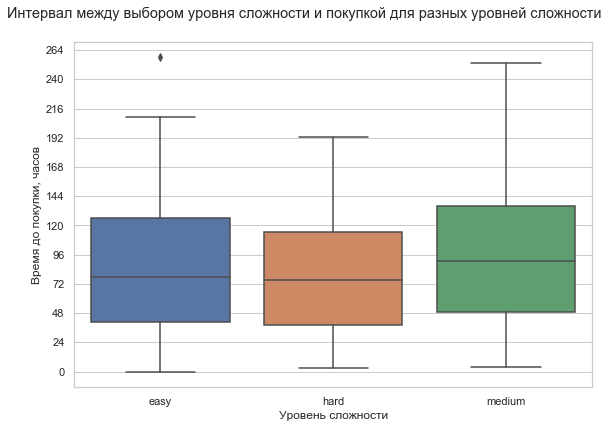

In [11]:
    fig = plt.figure(figsize=(8,6))
    fig.suptitle('Интервал между выбором уровня сложности и покупкой для разных уровней сложности')
    ax = fig.add_axes((0.1, 0.1, 0.9, 0.8))
    td = tdiff_by_lvl.copy()
    td.loc[:,'tdiff'] = td.tdiff.astype('timedelta64[h]')
    ax = sns.boxplot(x='level', y='tdiff', data=td, ax=ax)
    ax.set_xlabel("Уровень сложности")
    ax.set_ylabel("Время до покупки, часов")
    __ = ax.set_yticks([24*days for days in range(0,12)])
    # fig.show()

### Выводы по временным промежуткам

Как видим, покупатели уровня *medium* склонны думать над покупкой
дольше. Кроме того, в этой группе разброс времени принятия решения о
покупке максимален.

Обращаю внимание на то, что 75% пользователей принимают решение о
покупке платных тренировок не ранее, чем на вторые-третьи сутки после
выбора уровня. Возможно, интервал с 36 до 48 часов с выбора уровня будет
хорошим моментом для спецпредложений, акций и подобных усилий по
продвижению платных тренировок.

Дополнительно: оценить время от регистрации до оплаты для покупателей, выбравших разный уровень сложности
---------------------------------------------------------------------------------------------------------

Сделаем запрос в базу для получения таблицы времён по покупателям и
уровням сложности, затем расчитаем средние значения для уровней
сложности.

In [12]:
    cursor.execute(curr_cte + """ 
    select  
        user_id, lc.selected_level,  (pur.start_time - reg.start_time) as reg_time_diff 
    from 
        (select user_id, selected_level, start_time from events_2017 where event_type='level_choice') as lc 
        inner join 
        purchases_2017 as pur 
        using(user_id) 
        inner join 
        (select user_id, start_time from events_2017 where event_type='registration') as reg 
        using (user_id) 
    """) 
     
    ret = cursor.fetchall() 
    fromreg_by_lvl = pd.DataFrame.from_records(ret, columns=('uid', 'level', 'tdiff'), index='uid')
    fromreg_by_lvl.loc[:,'level'] = fromreg_by_lvl.level.astype('category')

    # Выведем средние по уровням сложности времена от регистрации до оплаты
    td1 = fromreg_by_lvl.copy()
    td1.loc[:,'tdiff'] = td1.tdiff.astype('timedelta64[h]')
    print(td1.groupby('level')['tdiff'].mean())

level
easy       93.629630
hard       86.416290
medium    101.702786
Name: tdiff, dtype: float64


Средние дают не слишком много информации, интереснее в виде боксплота:

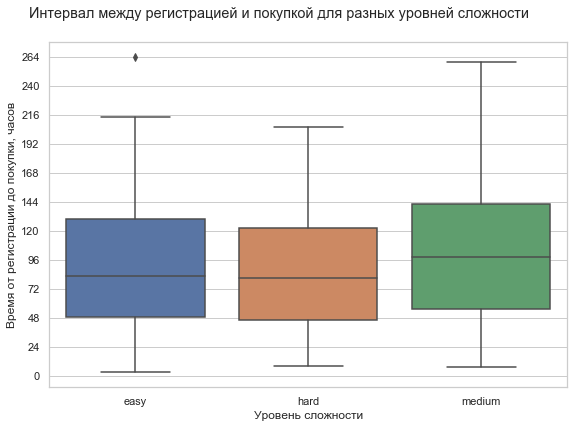

In [13]:
    fig = plt.figure(figsize=(8,6))
    fig.suptitle('Интервал между регистрацией и покупкой для разных уровней сложности')
    ax = fig.add_axes((0.1, 0.1, 0.9, 0.8))
    ax = sns.boxplot(x='level', y='tdiff', data=td1, ax=ax)
    ax.set_xlabel("Уровень сложности")
    ax.set_ylabel("Время от регистрации до покупки, часов")
    __ = ax.set_yticks([24*days for days in range(0,12)])
    # fig.show()

Как и в случае интервала от регистрации до оплаты, самые неторопливые
пользователи это те, кто выбирает уровень *medium*. Возможно, есть
способ поторопить их с оплатой, особенно ту четверть этих пользователей,
которая думает больше 6 дней (144+ часа).

Уровень *hard* демонстрирует относительно быстрый переход к оплате, для
почти 75% покупателей этот процесс занимает до 5 дней.

Уровень *easy* занимает промежуточное положение.

Выводы по исследованию в целом
------------------------------

* Выбранный пользователем уровень сложности очень заметно влияет на
  конверсию пользователей в покупателей — чем сложнее уровень, тем
  вероятнее оплата. Конверсия на уровне *easy* мала, на *medium* она
  превышает 20%, и на уровне *hard* свыше 35%.

* Влияние уровня сложности на промежуток времени от выбора уровня до
  оплаты или от регистрации до оплаты не столь заметно, хотя присутствует.
  Медленнее всех принимают решение об оплате пользователи, выбравшие
  уровень *medium*, быстрее всех — *hard*. Кроме того, на уровне *medium*
  максимальный разброс времени принятия решения об оплате.